### 1. Import libraries needed

In [1]:
import tensorflow as tf
import pathlib
import random
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### 2. Load Data and process

#### 2.1 Traverse data and set the labels

In [7]:
# locate data and list their dir
data_root = pathlib.Path.home().joinpath('Documents/Github/Dissertation/Data/')
for item in data_root.iterdir():
    print(item)

/Users/cyril/Documents/Github/Dissertation/Data/Kitti's Hog-Nosed Bat
/Users/cyril/Documents/Github/Dissertation/Data/Vampire Bat
/Users/cyril/Documents/Github/Dissertation/Data/.DS_Store
/Users/cyril/Documents/Github/Dissertation/Data/Indiana Bat
/Users/cyril/Documents/Github/Dissertation/Data/Egyptian Fruit Bat
/Users/cyril/Documents/Github/Dissertation/Data/Little Brown Bat
/Users/cyril/Documents/Github/Dissertation/Data/Giant Golden-Crowned Flying-Fox Bat


In [11]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths if "DS_Store" not in str(path)]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

689

In [12]:
# extract labels according to the dir of the data
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Egyptian Fruit Bat',
 'Giant Golden-Crowned Flying-Fox Bat',
 'Indiana Bat',
 "Kitti's Hog-Nosed Bat",
 'Little Brown Bat',
 'Vampire Bat']

#### 2.2 Data augmentation to enrich the dataset

In [15]:
# data augmentation to increase the size of the data
datagen = ImageDataGenerator(
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    shear_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest')

In [16]:
for img_path in tqdm(all_image_paths):
    label_path = img_path.replace(img_path.split('/')[-1], '')
    label_name = label_path.split('/')[-1]
    img = cv2.imread(img_path)
    img = img[:, :, [2, 1, 0]]
    x = img.reshape((1,) + img.shape)
    prefix = img_path.split("/")[-1].split('.')[0]
    counter = 0
    datagen.fit(x)
    for batch in datagen.flow(x, batch_size=32, save_to_dir=label_path, save_prefix=prefix):
        counter += 1
        if counter >= 5:
            break

100%|██████████| 689/689 [17:47<00:00,  1.55s/it]


In [17]:
# traverse the data set again
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths if "DS_Store" not in str(path)]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

4134

In [18]:
# set index of labels
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'Egyptian Fruit Bat': 0,
 'Giant Golden-Crowned Flying-Fox Bat': 1,
 'Indiana Bat': 2,
 "Kitti's Hog-Nosed Bat": 3,
 'Little Brown Bat': 4,
 'Vampire Bat': 5}

In [19]:
# build label data
all_image_labels = []
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 1, 3, 5, 2, 4, 0, 3, 4, 3]


In [20]:
# laod and process function
img_size = (224, 224)
def load_and_preprocess_image(image):
    image = cv2.imread(image)
    image = cv2.resize(image, img_size)
    image = image[:, :, [2, 1, 0]]
    image = image.astype('float64')
    image /= 255.0  # normalize to [0,1] range

    return image

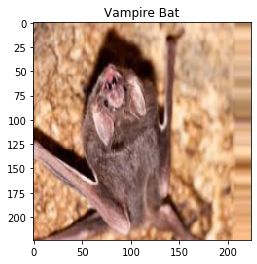

In [22]:
# An example
example_path = all_image_paths[10]
label = all_image_labels[10]

plt.imshow(load_and_preprocess_image(example_path))
plt.title(label_names[label].title())
print()

### Load all images and process

In [24]:
images = []
for image_path in tqdm(all_image_paths):
    processed_image = load_and_preprocess_image(image_path)
    images.append(processed_image)
images = np.asarray(images)

100%|██████████| 4134/4134 [00:39<00:00, 105.44it/s]


In [25]:
all_image_labels = np.asarray(all_image_labels)
all_image_labels = to_categorical(all_image_labels, num_classes=6)

In [28]:
np.save('bat_img.npy', images)
np.save('bat_label.npy', all_image_labels)

In [27]:
images.shape

(4134, 224, 224, 3)

### 2 Train the model

#### 2.1 Prepare training and testing data

In [65]:
# split data into training data and testing data
X_train, X_val, y_train, y_val = train_test_split(images, all_image_labels, test_size=0.1, random_state=3)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(3701, 224, 224, 3)
(412, 224, 224, 3)
(3701, 13)
(412, 13)


#### 2.2 Build(Load)) the model

In [2]:
# Transfer learning to load pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = Inception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [71]:
FC_NUMS = 1024
IMAGE_SIZE = 224
NUM_CLASSES = 13
TRAINABLE_LAYERS = 2

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_NUMS, activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.05)(x)
prediction = Dense(NUM_CLASSES, activation='softmax')(x)

In [72]:
model = Model(inputs=base_model.input, outputs=prediction)
model.summary()
print("layer nums:", len(model.layers))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [73]:
for layer in model.layers[:TRAINABLE_LAYERS]:
    layer.trainable = True
for layer in model.layers:
    print("layer.trainable:", layer.trainable)

layer.trainable: True
layer.trainable: True
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: False
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True
layer.trainable: True


In [74]:
LEARNING_RATE = 1e-3
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callbacks = [
tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
tf.keras.callbacks.TensorBoard(log_dir='./logs'),
tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [76]:
epochs = 100
batch_size = 16

In [77]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                              epochs = epochs, verbose=1,
                              validation_data = (X_val, y_val),
                               callbacks=callbacks)

  ...
    to  
  ['...']
Train for 232 steps, validate on 412 samples
Epoch 1/100
 20/232 [=>............................] - ETA: 10:47 - loss: 2.5402 - accuracy: 0.1546WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [ ]:
train_history = []
for i, model in enumerate(model_list):
    history = train_model(model, callbacks)
    train_history.append(history)
    history.save("model_num"+i+'.h5')

In [ ]:
result = model.evaluate(x_val, y_val)
print("loss: {}".format(result[0]))
print("accuracy: {}".format(result[1]))